In [1]:
protein = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF"
from disassembly.simulate_proteolysis import (
    simulate_proteolysis,
    enzyme_set,
    enzyme,
)
from disassembly.util import amino_acids

n_generate = 250

k_enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
    ],
    [1],
    [1],
)

kr_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
    ],
    [1],
    [1],
)

viat_enzymes = enzyme_set(
    [
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1],
    [1],
)

krviat_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1],
    [1, 1],
)

random_enzymes = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [2]:
generated_peptidomes = {"name": [], "peptidome": []}

names = ["k", "kr", "krviat", "viat", "random"]


for enz, name in zip(
    [k_enzymes, kr_enzymes, krviat_enzymes, viat_enzymes, random_enzymes], names
):
    print(name)
    for i in range(10):
        print(f"\r{i}", end="", flush=True)
        generated_peptidome = simulate_proteolysis(
            protein,
            n_start=1,
            n_generate=n_generate,
            endo_or_exo_probability=[0.9, 0.1],
            enzymes=enz,
            graph=False,
            verbose=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)
    print("\n")

k
0

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:218: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


9

kr
9

krviat
9

viat
9

random
9



In [3]:
from disassembly.util import KL, normalize_dict
from disassembly.estimate_parameters import compare

comparisons = {}
for i in range(len(generated_peptidomes["peptidome"])):
    name_comp_1 = generated_peptidomes["name"][i]
    peptidome_comp_1 = generated_peptidomes["peptidome"][i]
    comparisons[name_comp_1] = {}
    for j in range(len(generated_peptidomes["peptidome"])):
        name_comp_2 = generated_peptidomes["name"][j]
        peptidome_comp_2 = generated_peptidomes["peptidome"][j]
        p, q = compare(peptidome_comp_1, peptidome_comp_2)
        err = KL(p, q) + KL(q, p)
        comparisons[name_comp_1][name_comp_2] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


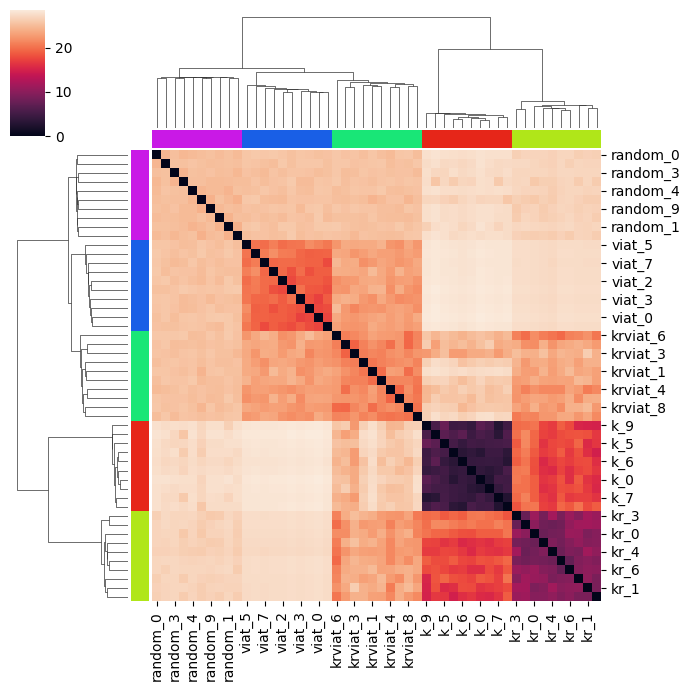

In [4]:
import seaborn as sns

lut = dict(zip(names, sns.hls_palette(len(names), l=0.5, s=0.8)))

lst = []
for i, n in enumerate(names):
    lst += [f"{n}"] * 10

row_colors = pd.DataFrame(lst)[0].map(lut)


sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)

In [5]:
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme


# Say we want to estimate parameters for K enzyme.
enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [0, 0, 1],  # activities
    [0,0, 1],  # abundances
)


true_dict, sequence_graph = simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=n_generate,
    endo_or_exo_probability=[0.9, 0.1],
    enzymes=enzymes,
    graph=True,
)

 41 / 250 (45)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:218: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 249 / 250 (283)
180 unique peptides. 251 total


Iteration: 0
	V: 24.91 | 25.97
V better!
	V: 24.47 | 24.91
V better!
	V: 24.29 | 24.47
V better!
	V: 22.99 | 24.29
V better!
	V: 24.01 | 22.99
	I: 22.48 | 22.99
I better!
	I: 22.89 | 22.48
	L: 24.11 | 22.48
	E: 24.68 | 22.48
	Q: 23.83 | 22.48
	D: 25.13 | 22.48
	N: 23.10 | 22.48
	H: 24.58 | 22.48
	W: 23.22 | 22.48
	F: 23.01 | 22.48
	Y: 24.04 | 22.48
	R: 24.44 | 22.48
	K: 23.45 | 22.48
	S: 25.06 | 22.48
	T: 24.14 | 22.48
	M: 24.72 | 22.48
	A: 23.51 | 22.48
	G: 24.43 | 22.48
	P: 24.37 | 22.48
	C: 23.56 | 22.48
 exo: 23.98 | 23.65 (0.25)
 exo: 23.68 | 23.65 (0.25)
 exo: 23.36 | 23.36 (0.15)
 exo: 22.16 | 22.16 (0.05)
 exo: 23.77 | 22.16 (0.10)
 exo: 24.33 | 22.16 (0.10)
 exo: 23.52 | 22.16 (0.10)
 exo: 22.39 | 22.16 (0.10)
 exo: 22.61 | 22.16 (0.10)
 exo: 24.20 | 22.16 (0.10)
 exo: 23.44 | 22.16 (0.10)
 exo: 23.37 | 22.16 (0.10)
 exo: 22.37 | 22.16 (0.10)
 exo: 22.96 | 22.16 (0.10)
 exo: 23.33 | 22.16 (0.10)
 exo: 23.43 | 22.16 (0.10)
 exo: 23.03 | 22.16 (0.10)
 exo: 24.04 | 22.16 (0.10)
 

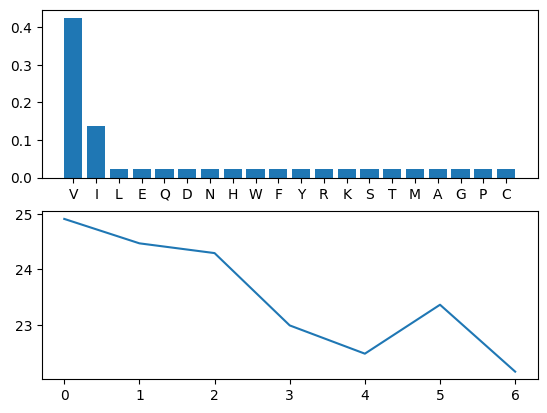

In [6]:
from disassembly.estimate_parameters import ParameterEstimator

pe = ParameterEstimator()

parameters = pe.estimate(
    protein, true_dict, n_generate=n_generate, n_iterations_endo=1, n_iterations_exo=20
)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].bar(parameters["endo"].keys(), parameters["endo"].values())
axs[1].plot(pe.best_losses)
print(parameters["exo"])

 199 / 200 | 0.68, kl: 0.04, reg: 0.64  | nz: 730 | 

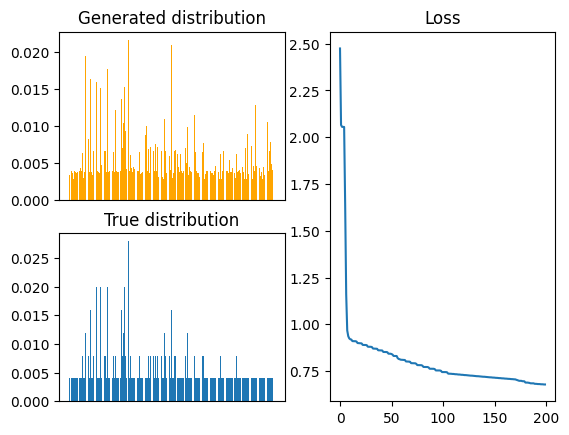

In [7]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

wegd = WeightEstimatorGD(lr=0.1, n_iterations=200, lam1=0.01, lam2=0.01)

G = wegd.run(true_dict, verbose=True, parameters=parameters)
generated = wegd.generated
losses = wegd.losses
weights = wegd.weights

fig, axs = plt.subplot_mosaic(
    [["generated", "loss"], ["true", "loss"]], width_ratios=[2, 2]
)


axs["true"].bar(
    true_dict.keys(), [v / sum(true_dict.values()) for v in true_dict.values()]
)
axs["generated"].bar(
    generated[len(generated.keys()) - 1].keys(),
    generated[len(generated.keys()) - 1].values(),
    color="orange",
)
axs["loss"].plot(losses)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["loss"].set_title("Loss")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

0.9277352543899144

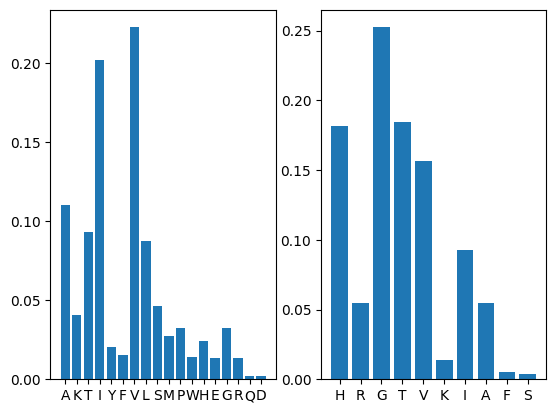

In [8]:
from disassembly.cut_site import get_p1

p1_endo, p1_exo,  n_endo, n_exo = get_p1(G, 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

0.9877962792211314

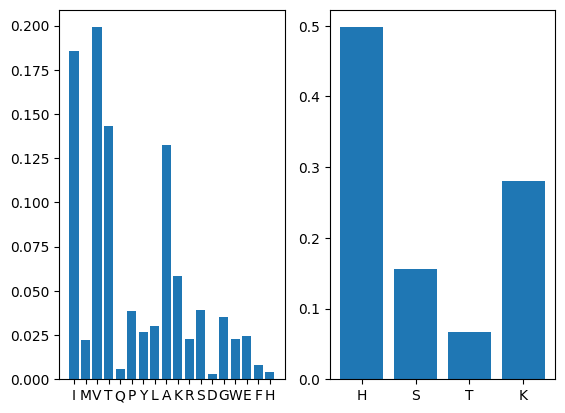

In [9]:

p1_endo, p1_exo,  n_endo, n_exo = get_p1(sequence_graph, 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

In [10]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

print("Real")
real_disassembly_indexes = get_disassembly_indexes_mc(sequence_graph, N_particles=10000)
print(get_disassembly(true_dict, real_disassembly_indexes))
print("Estimated")
mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(true_dict, mc_di)

Real

 Averaged DI: 2.07
5.251053443560777
Estimated

 Averaged DI: 2.71


11.088439784968124

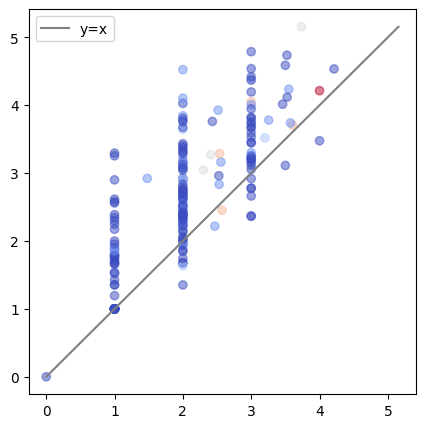

In [11]:
from disassembly.util import plot_di_correlation

plot_di_correlation(true_dict, real_disassembly_indexes, mc_di)

# Check if simulated proteolysis has a reasonable distance


In [12]:
import pandas as pd


df = pd.read_csv("../data/enzymes/processed.csv")
df = df[df["Protein Accession"] == "ACTB"]
df.set_index(["Peptide", "Protein Accession"], inplace=True)

In [13]:
pre_df = {}

for name, peptidome in zip(
    generated_peptidomes["name"], generated_peptidomes["peptidome"]
):
    pre_df[name] = peptidome
df_simulated = pd.DataFrame(pre_df)
df_simulated = df_simulated.reset_index().rename(columns={"index": "Peptide"})
df_simulated.head()

,Peptide,k_0,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,RGILTLKYPIEHGIVTNWDDME,5.0,3.0,3.0,7.0,3.0,4.0,10.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EITALAPSTMKIKIIAPPER,3.0,1.0,8.0,1.0,1.0,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YSVWIGGSILASLSTFQQMWIS,16.0,25.0,18.0,20.0,18.0,17.0,4.0,18.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IKIIAP,15.0,9.0,16.0,2.0,1.0,6.0,1.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
merged = df.reset_index().merge(df_simulated, left_on="Peptide", right_on="Peptide")
merged = merged.set_index("Peptide").drop(columns=["Protein Accession"])
samples = merged.columns

In [15]:
data_dict = {}

for sample in samples:
    sample_data = merged[sample].dropna().reset_index()

    protein_dict = {}

    peptide_dict = {}

    for i, row in sample_data.iterrows():
        peptide = row["Peptide"]
        abundance = row[sample]
        peptide_dict[peptide] = abundance
    protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF': {'KDLYANTVLSGGTTMYPGIADR': 0.0,
   'PEEHPVLLTEAPLNPK': 0.0,
   'GMGQKDSYVGDEAQSKRGILTL': 0.0,
   'VGMGQKDSYVGDEAQSK': 0.0,
   'VPIYEGYALPHAILR': 0.0,
   'FEQEMATAASSSSLEK': 0.0,
   'VAPEEHPVLLTEAPLNPK': 0.0,
   'QEYDESGPSIVHR': 0.0,
   'TTGIVMDSGDGVTHTVPIYEGYALPHAILR': 0.0,
   'DLYANTVLSGGTTMYPGIADRMQK': 0.0,
   'HQGVMVGMGQK': 0.0,
   'GMGQKDSYVGDEAQSKRGIL': 0.0,
   'GMGQKDSYVGDEAQSKR': 0.0,
   'TTGIVMDSGDGVTHTVPIYEGYALPH': 0.0,
   'AGDDAPRAVFPSIVGRPRHQGVM': 21.031469679332115,
   'PSIVGRPRHQGVMVGMGQKDSYVGDEAQSK': 0.0,
   'ILTERGYSFTTTAERE': 0.0,
   'DSYVGDEAQSK': 0.0,
   'GFAGDDAPRAVFPS': 0.0,
   'GDEAQ

In [16]:
comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

In [17]:
import re

pattern1 = r"_[0-9]"
pattern2 = r"[0-9]"

groups = [re.sub(pattern2, "", re.sub(pattern1, "", s)) for s in samples]

synthetic = ["in vitro"] * 40 + ["in silico"] * 50

design = pd.DataFrame({"sample": samples, "group": groups, "synthetic": synthetic})

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


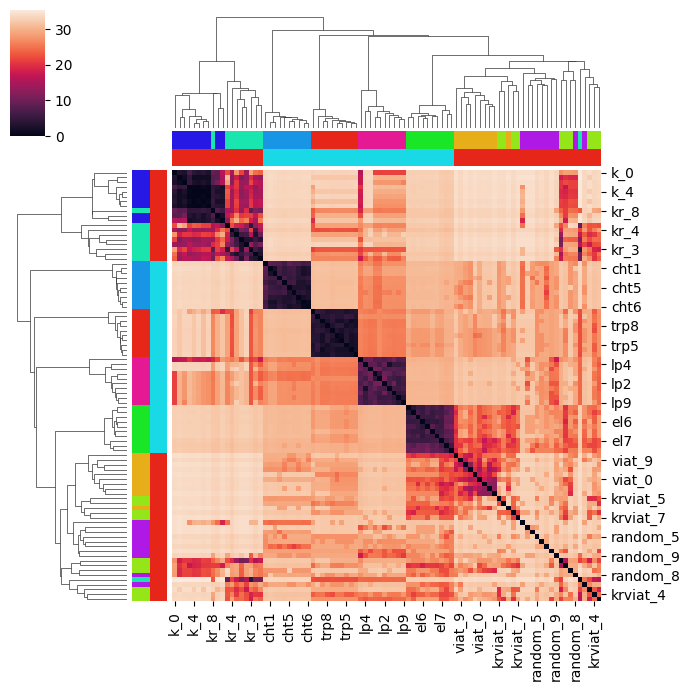

In [18]:
import seaborn as sns

labels1 = design["group"]
lut = dict(zip(set(labels1), sns.hls_palette(len(set(labels1)), l=0.5, s=0.8)))
row_colors1 = design["group"].map(lut)

labels2 = design["synthetic"]
lut = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = design["synthetic"].map(lut)

comps_df = pd.DataFrame(comparisons)

sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
)